In [6]:
import warnings
warnings.filterwarnings('ignore')


The indiegogo datasets are available in kaggle https://www.kaggle.com/kingburrito666/indiegogo-project-statistics, but where originally posted in https://webrobots.io/indiegogo-dataset/ (dates 05/14/2016 to 04/15/2017 ). I combined these datasets into one data set of about ~1 GB. 


First we have to clean the dataset because they were scraped and aren't very tidy. I mostly used the cleaning algorithms from https://www.kaggle.com/kahungwong/exploration-on-closed-projects. Here is the cleaning algorithm: 

In [7]:
import sys
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')


print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas
print('pandas: {}'.format(pandas.__version__))
# scikit-learn
import numpy as np

import pandas as pd
import re

# Load dataset
url = "indie.csv"

dataset = pandas.read_csv(url)
#print(dataset['category'])
#print(dataset["DATE"].loc[dataset["DATE"]=='12/31/2018'])

print(list(dataset.columns.values))

useless_columns = ["url","category_url","igg_image_url","compressed_image_url","card_type",
                   "category_slug","source_url","friend_team_members","friend_contributors"]
data_clean = dataset.drop(useless_columns, axis = 1)

for col in ['balance', 'collected_percentage']:
    data_clean[col] = pd.to_numeric(data_clean[col].str.replace(r"\D",''))

# from Juan Corporan's Analyzing a Project's Success notebook. To transform the time left.
def get_daysleft(time):
    if "hour" in time:
        return float(re.sub(r"\D", "", time))/24
    elif "day" in time:
        return float(re.sub(r"\D", "", time))
    else:
        return 0.0

data_clean.amt_time_left = data_clean.amt_time_left.apply(get_daysleft)

# transform in_forever_funding into indicator variable
def split_foreverfunding(x):
    if "true" in str(x).lower():
        return True
    elif "false" in str(x).lower() :
        return False
    else:
        return np.nan
    
data_clean.in_forever_funding = data_clean.in_forever_funding.apply(split_foreverfunding) 

# transform partner_name into indicator variable
def have_partner(x):
    if "null" in str(x).lower():
        return False
    else:
        return True

data_clean['partner_name'] = data_clean.partner_name.apply(have_partner)

# lower the string in category_name
data_clean.category_name = data_clean.category_name.str.lower()
data_clean['category_name'] = data_clean['category_name'].astype('category')

data_clean.head(5) 

idx = data_clean.groupby(['id'])['balance'].transform(max) == data_clean['balance']
# now we can safely remove the duplicated rows since they contains the most updated records even they are duplicated. 
data_clean = data_clean[idx].drop_duplicates()

data_clean['goal'] = data_clean['balance']*100/data_clean['collected_percentage']
# collected_percentage values can be zero
data_clean.loc[data_clean['goal'] == np.inf, 'goal'] = np.nan

# define success for funding
data_clean['success'] = data_clean['collected_percentage'].apply(lambda x: np.where(x >= 100,True,False))

data_clean.head()





#print(dataset)
print("Done!")

Python: 3.5.4 |Anaconda 2.5.0 (x86_64)| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
scipy: 0.17.0
numpy: 1.11.3
matplotlib: 1.5.1
pandas: 0.23.4
['Unnamed: 0', 'id', 'title', 'nearest_five_percent', 'tagline', 'cached_collected_pledges_count', 'igg_image_url', 'compressed_image_url', 'balance', 'currency_code', 'amt_time_left', 'url', 'category_url', 'category_name', 'category_slug', 'card_type', 'collected_percentage', 'partner_name', 'in_forever_funding', 'friend_contributors', 'friend_team_members', 'source_url']
Done!


Now the data analysis begins. 

In [21]:
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas
print('pandas: {}'.format(pandas.__version__))
# scikit-learn
import numpy as np
import scipy as sp
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt



#dataT is the dataset of fully funded projects.
#dataS is a dataset that gives you the proportion of fully funded projects over the total number of projects
#dataSD2 gives you the normalized standard deviation and skewness of the funding goals of succesful projects
dataT=data_clean[data_clean["success"]==True]
dataS=data_clean.groupby(data_clean['category_name'],as_index=False)['success'].agg({'True':sum, False: lambda x: len(x)-sum(x), 'True_Pct': lambda x: float(sum(x))/len(x)})
dataSD=dataT.groupby('category_name',as_index=False)['goal'].agg({'normalized stdev': (lambda x: np.std(x)/np.mean(x)),'skew': lambda x: sp.stats.skew(x) })
dataSD2=dataSD.melt('category_name', var_name='normalized stdev', value_name='skew')



def sb_BarPlot(data,label,measure,boolean):
    a4_dims = (11.0, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
 
    labels=['skewness', 'normalized standard deviation']
    sns.barplot(y=label, x=measure, hue=boolean, data=data,orient="horizontal")

    ax.set_title('Standard deviation and skewness of succesful funding goals')
    ax.set_xlabel('')
    ax.set_ylabel('Category')
    ax.legend().set_title('')
    


    plt.show()
    plt.close()


def sb_BarPlotHueLess(data,label,measure,boolean):
    a4_dims = (11.0, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    #plot = sns.barplot(y=label, x=measure,hue=boolean,ax=ax, data=data,orient="horizontal")
    sns.barplot(y=label, x=measure, ax=ax, data=data,orient="horizontal")
    plt.show()



#plt.savefig('skew')
#sb_BarPlotHueLess(dataS,"category_name","True_Pct","True")
#plt.savefig('success')
def sb_BoxPlot(data,label,measure,boolean):
    a4_dims = (11.0, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    
    
    ax.set(xscale="log")
    sns.boxplot(y=label, x=measure,ax=ax, data=data,orient="horizontal")
    ax.set_title('Funding goals of succesful projects')
    ax.set_xlabel('Goal (USD)')
    ax.set_ylabel('Category')
    plt.show()
    plt.clf()
    plt.close()


    

#sb_BoxPlot(dataT,"category_name","goal","success")
#plt.savefig('box')
#sb_SwarmPlot(dataT,"category_name","goal","success")

#sb_BarPlot(data_clean,"category_name","goal","success")


def sb_Dist(data, measure):
    a4_dims = (11.0, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    ax.set(xscale="log")
    #ax.set_ylim(1,30)
    sns.distplot(data[measure],kde=False)
    plt.show()


#sb_Dist(dataBlog,"goal")


print("Done!")

matplotlib: 1.5.1
pandas: 0.23.4
Done!


boxplot of funding goals of succesful projects


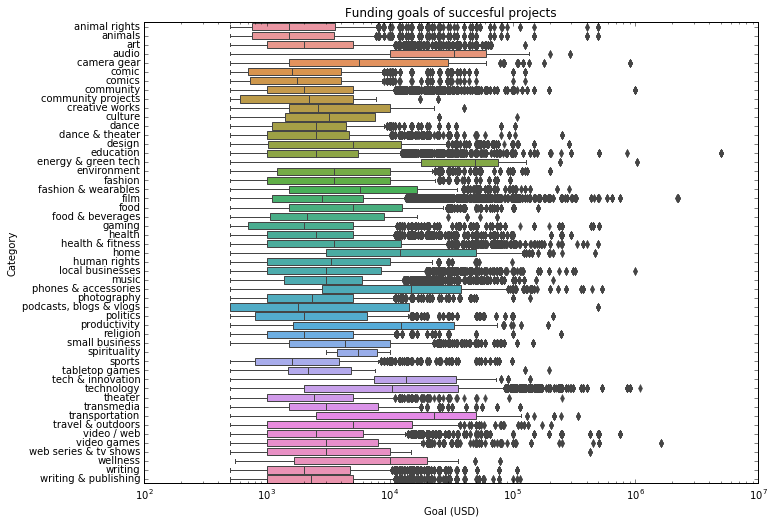

skewness and normalized standard deviation of funding goals of succesful projects


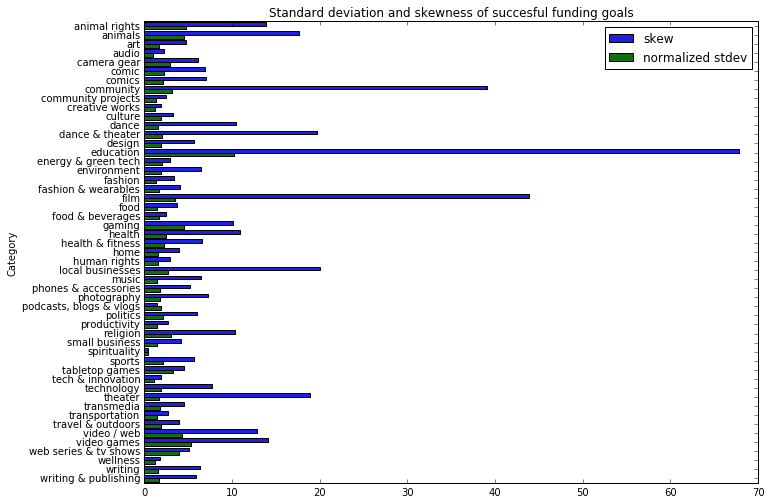

In [24]:
print('boxplot of funding goals of succesful projects')
sb_BoxPlot(dataT,"category_name","goal","success")
print('skewness and normalized standard deviation of funding goals of succesful projects')
sb_BarPlot(dataSD2,"category_name","skew","normalized stdev")
